# 第3单元：音频Transformer架构

## Transformer模型回顾

本课程中，我们主要关注Transformer模型以及它们如何应用于音频任务。虽然您不需要了解这些模型的内部细节，但了解使它们工作的主要概念很有用，因此我们在本小节中回顾一下关于Transformer的知识。有关transformer的深入了解，请查看我们的NLP课程。

### Transformer的原理是什么？

Transformer架构最早是为文本翻译的任务而设计的。它的结构如下：

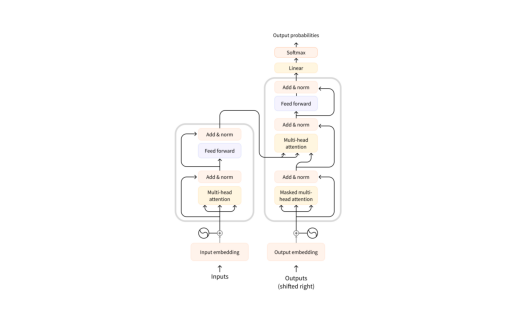

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.1transformers.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

左边是编码器（encoder），右边是解码器（decoder）。

编码器负责接收模型的输入，本例中是一系列文本标记(toen)，并构建其表征（representation，或称特征，feature）。Transformer模型的编码器在经过训练后能够从输入中提取并理解信息。

解码器负责使用编码器生成的表征（特征向量）以及其他输入（先前预测的标记）来生成目标序列。Transformer模型的解码器在经过训练能够根据表征中蕴含的信息生成输出序列。在原始设计中，输出序列由文本标记组成。

有的Transformer模型只使用编码器（适用于需要理解输入的任务，例如分类），或者只使用解码器（适用于生成文本的任务）。BERT就是一个只使用编码器的例子；GPT2则是一个只使用解码器的例子。

Transformer模型的一个关键特征是它们使用特殊的层，称为注意力层（attention layers）。这些层告诉模型在计算特征表示时，特别关注输入序列中的某些元素，而忽略其他元素。

### 使用Transformer进行音频处理

本课程中，我们将介绍的音频模型通常具有上图所示的标准Transformer架构，但会在输入或输出端稍作修改来适应音频而非文本序列。由于所有这些模型本质上都是Transformer，因此它们的大部分架构都是相同的，主要区别在于它们的训练和使用方式。

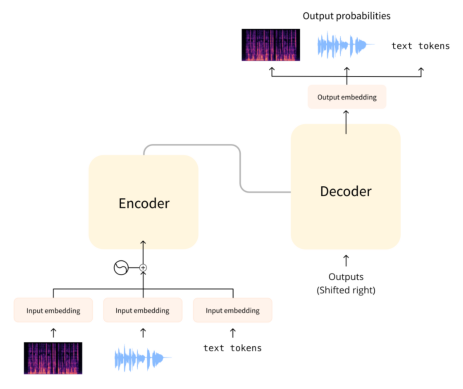

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.2transformers_blocks.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

对于音频任务，输入和/或输出序列可以是音频而非文本：

自动语音识别（ASR）：输入为语音，输出为文本。
文本到语音（TTS）：输入为文本，输出为语音。
语音分类：输入为语音，输出为类别概率——对于序列中的每个元素，或者对于整个序列的单个类别概率。
语音转换或语音增强：输入和输出均为语音。
有几种不同的方法可以将音频数据转换为Transformer能够处理的格式。主要的区别在于是使用音频的原始波形作为模型的输入序列，还是使用其时频谱作为输入序列。

### 模型的输入格式

音频模型的输入可以是文本或声音。我们的目标是将此输入转换为一个嵌入向量（embedding vector），以便Transformer架构可以处理。

#### 文本输入
文本到语音模型（TTS）接受文本作为输入。这与原始Transformer或任何其他NLP模型的工作方式相同：首先对文本进行标记化（tokenization），得到一系列文本标记。然后将此序列通过输入嵌入层，将标记转换为512维向量。然后将这些嵌入向量传递到Transformer编码器中。

#### 波形输入
自动语音识别模型（ASR）接受语音作为输入。为了使用Transformer解决ASR任务，我们首先需要以某种方式将音频转换为嵌入向量序列。

Wav2Vec2和HuBERT一类的模型直接使用音频波形作为模型的输入。如您在音频数据章节中所见，波形是一个浮点数序列，其中的每个数表示某个时间点的幅值。我们首先将原始波形标准化为零均值和单位方差的序列，这有助于标准化不同音量（振幅）的音频样本。

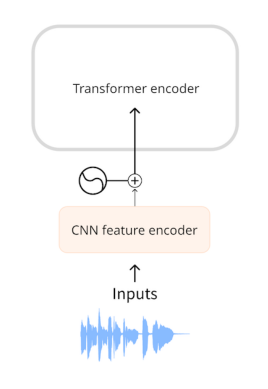

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.3wav2vec2-input.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

完成标准化后，我们将该波形序列被转换为嵌入向量序列。这是通过一个小型卷积神经网络（CNN）完成的，称为特征编码器（feature encoder）。该网络的每个卷积层都处理输入序列，对音频进行下采样（subsampling）以减少序列长度，直到最后一个卷积层输出512维向量，即每25毫秒音频的嵌入向量（embedding vector）。当输入序列被转换为这样的嵌入向量序列（embedding vector sequence）后，Transformer便可以像往常一样处理数据了。

#### 时频谱输入
使用原始波形作为输入的一个缺点是它们往往具有较长的序列长度。例如，采样率为16 kHz的30秒音频输入的长度为30 * 16000 = 480000。长的序列需要在Transformer模型中进行更多的计算，因此会增加内存使用量。

因此，我们认为在大多数情况下原始音频并不是最有效率的表示音频输入的方式。通过使用时频谱（spectrogram），我们可以以更紧凑的形式表示相同数量的信息。

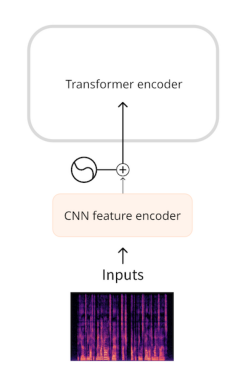

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.4whisper-input.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

Whisper等模型首先将波形转换为一个对数梅尔频谱图（log-mel spectrogram）。Whisper会将音频分成数个30秒的片段，每个片段的对数梅尔频谱图的形状为(80, 3000)，其中80是梅尔频率的数量，3000是序列的长度。通过将音频转换为对数梅尔频谱图，我们不仅减少了输入数据的数量，而且更重要的是，转换后的序列长度远远小于波形的长度。。最后，对数梅尔频谱图由一个小型CNN处理，转换为嵌入向量序列，然后像往常一样输入Transformer。

无论是波形还是时频谱输入，我们都会先使用一个小型的神经网络在Transformer之前将输入转换为嵌入向量序列，然后由Transformer接管并完成其工作。

### 模型的输出格式

Transformer架构会输出一个隐藏状态向量（hidden-state vectors）的序列，也称为输出嵌入向量（output embedding）。我们的目标是将这些向量转换为文本或音频输出。

#### 文本输出
自动语音识别模型的目标是预测一个文本标记（text token）的序列。这是通过在Transformer的输出上添加一个语言建模（language modeling）头——通常是一个单独的线性层———然后在transformer的输出上添加一个softmax来完成的。该输出预测的是词汇表中文本标记的概率。

#### 时频谱输出
对于生成音频的模型，例如文本到语音（TTS）模型，我们需要添加能够生成音频序列的层。通常会生成一个频谱图，然后使用另一个神经网络（称为声码器（vocoder））将该频谱图转换为波形。

举个例子，SpeechT5 TTS模型的输出是一个768元素向量的序列。线性层将该序列投影到一个对数梅尔频谱图上。然后，一个由线性层和卷积层组成的后处理网络（post-net）会对频谱图进行降噪处理。最后，我们使用声码器生成输出的音频波形。

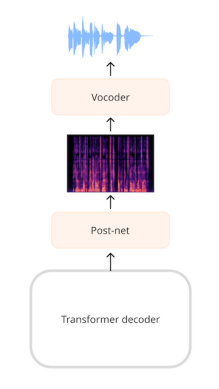

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.5speecht5.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

<font style=background:Green>💡如果我们对波形进行短时傅里叶变换（STFT）得到其时频谱，我们可以通过其逆向过程（ISTFT）重新得到原始的波形。这是因为STFT生成的时频谱包含了幅值和相位两部分的信息，而这两部分信息都是重建波形所必需的。然而，音频深度学习模型所生成的时频谱往往仅包含了幅值信息。为了将这样的时频谱转化为波形，我们需要通过某种方式估计其相位信息，这便是声码器的功能。</font>

#### 波形输出
除了生成时频谱作为中间输出的方法外，有些模型也可以直接生成波形输出。但是，目前🤗 Transformers中没有包含能够直接生成波形的模型。

### 小节

总结一下：大多数音频Transformer模型都是相似的——它们都是基于相同的Transformer架构和注意力层构建的。不过，有些模型只使用Transformer的编码器部分，而有些模型则同时使用编码器和解码器。

我们也学习了如何在Transformer模型中将音频作为输入或者输出。在ASR、TTS等音频任务中，我们可以改变模型中的部分输入层来将数据转换为嵌入向量序列，也可以改变一部分输出层来将生成的嵌入向量序列转化为输出格式，而Transformer的主体部分保持不变。

接下来，我们将学习几种不同的训练方法来训练一个自动语音识别模型。

## CTC结构

CTC结构（Connectionist Temporal Classification）是一种仅使用Transformer编码器（encoder）结构的语音识别（ASR）模型。使用该架构的模型包括Wav2Vec2、HuBERT、M-CTC-T等等。

仅含编码器的Transformer（encoder-only Transformer）是最简单的Transformer，因为它只使用模型的编码器部分。编码器读取输入序列（音频波形）并将其映射到隐藏状态序列（sequence of hidden-states），也称为输出嵌入（output embedding）。

使用CTC模型时，我们对隐藏状态序列进行额外的线性映射以获得类标签预测。类标签为字母表中的字母（a、b、c，…）。这样，我们就能够使用一个很小的分类头来预测目标语言中的任何单词，因为词汇表（vocabulary）只需要包含26个字符加上一些特殊的标记。

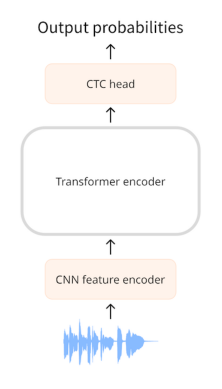

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.5wav2vec2-ctc.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

到目前为止，这与我们在NLP中使用BERT模型的做法非常相似：仅编码器的Transformer模型将文本标记映射到一系列编码器隐藏状态，然后我们应用线性映射，为每个隐藏状态预测一个类标签。

棘手的问题在于：在语音识别中，我们不知道音频输入和文本输出的对齐方式（alignment）。我们知道语音的顺序与文本的转录顺序相同（对齐是单调的），但我们不知道转录文本中的字符如何与音频对齐。这就是CTC算法的用武之地。

<font style=background:Green>💡 在NLP模型中，词汇表（vocabulary，也称字典）通常由数千个标记组成，这些标记不仅描述单个字符，还描述单词的部分甚至整个单词。然而对于CTC模型，较小的词汇表效果最好，我们一般会将其保持在50个字符以下。我们不关心字母的大小写，因此仅使用大写（或仅使用小写）就足够了。数字则被拼写为单词，例如`"20"`变成`"twenty"`。除了字母，我们还需要至少一个单词分隔符标记（空格，space）和一个填充标记（padding token）。与NLP模型一样，填充标记允许我们将多个示例组合成批次，但它也是模型将预测的沉默标记。在英语中，保留`'`字符也很有用——毕竟，`"it's"`和`"its"`的含义完全不同。</font>

### 我们到底该怎么对齐呢？

自动语音识别（ASR）涉及将音频作为输入并产生文本作为输出。我们有几种选择来预测文本：

预测单个字母
预测音素（phoneme）
预测单词标记（word token）
ASR模型会使用含有(音频, 文字)对的数据集进行训练，这些数据集的文字信息通常是人工转录的。通常，数据集不包含任何时间信息，也就是说，我们不知道输入和输出序列应该如何对齐。

假设我们有一个长度为一秒钟的音频文件。在Wav2Vec2中，模型首先使用CNN特征编码器对音频输入进行下采样，将其映射到较短的隐藏状态序列，其中每20毫秒的音频会对应一个隐藏状态向量（hidden-states vector）。对于一秒的音频，我们将生成的隐藏状态序列传递给Transformer编码器。 （从输入序列中提取的音频片段会有部分重叠，因此即使每20毫秒会生成一个隐藏状态向量，但每个向量实际上包含了25毫秒的音频信息。）

Transformer的编码器会对每个隐藏状态向量产生一个输出预测，因此我们从Transformer中得到一个长度同样为50的输出向量序列。该序列中的每个向量的维度为768. 因此，该示例中Transformer编码器的输出序列的形状为(768, 50)。每个预测值包含了25毫秒的音频信息，而音素（phoneme）通常会持续超过25毫秒。因此，我们这里预测音素的效果会好于预测整个单词。CTC在小词汇表上的效果更好，因此我们将预测字母。

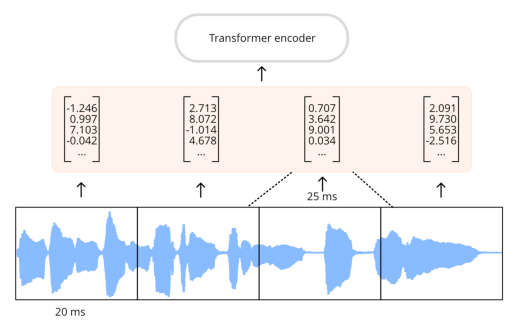

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.6cnn-feature-encoder.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

为了进行文本预测，我们使用一个线性层（“CTC头”）将768维的编码器输出映射到我们的字符标签。然后，模型会预测一个(50, 32)的张量，其中32是词汇表中的标记数。由于我们对序列中的每个特征都进行了一次预测，因此每秒音频会有50个字符预测。

然而，如果我们简单地每20毫秒预测一个字母，我们的预测结果可能会是这样的：

BRIIONSAWWSOMEETHINGCLOSETOPANICONHHISOPPONENT'SSFAACEWHENTHEMANNFINALLLYRREECOGGNNIIZEDHHISSERRRRORR ...

仔细观察这个输出，我们可以发现它看起来有一点像英语，但有很多重复的字母。这是因为我们的模型必须每20毫秒都输出一些东西，而如果某个字母的持续时间超过了20毫秒，模型就会输出重复的字母。我们无法避免这种情况，特别是在训练时我们不知道转录文本的时间信息。而CTC就是一个帮助我们过滤重复字母的方法。

（在实际操作中，预测的序列还有可能包含很多填充标记（padding token），用于表示模型不太确定音频表示的是什么，或者用于表示字符之间的空白。为了清晰起见，我们从示例中删除了这些填充标记。音频片段之间的部分重叠也是字符重复的另一个原因。）

### CTC算法

CTC算法的关键在于使用一个特殊的标记，通常称为空白标记（blank token）。这是一个我们人为加入词汇表的额外标记。在这个例子中，空白标记被表示为_。我们用这个特殊的标记来表示字母组之间的硬边界。

CTC模型的完整输出类似于如下的序列：
B_R_II_O_N_||_S_AWW_|||||_S_OMEE_TH_ING_||_C_L_O_S_E||TO|_P_A_N_I_C_||_ON||HHI_S||_OP_P_O_N_EN_T_'SS||_F_AA_C_E||_W_H_EN||THE||M_A_NN_||||_F_I_N_AL_LL_Y||||_RREE_C_O_GG_NN_II_Z_ED|||HHISS|||_ER_RRR_ORR||||

该序列中的|标记是单词分隔符。在这个例子中，我们使用|而不是空格作为单词分隔符，这样可以更容易地看出单词的分隔位置，但它们的作用是一样的。

CTC空白标记使我们能够过滤掉重复的字母。例如预测序列中的最后一个单词，_ER_RRR_ORR。如果没有CTC空白标记，这个单词看起来是这样的：

ERRRRORR

如果我们简单地去掉非CTC结果中的重复字符，那么它就变成了EROR。显然这不是正确的拼写。但是有了CTC空白标记，我们就可以在每个字母组中去掉重复的字母：

_ER_RRR_ORR

变为：

_ER_R_OR

最后我们去掉空白标记_，得到最终的单词：

ERROR

如果我们将这种逻辑应用到整个文本，包括|，并将剩余的|字符替换为空格，那么最终的CTC解码输出会变成：

BRION SAW SOMETHING CLOSE TO PANIC ON HIS OPPONENT'S FACE WHEN THE MAN FINALLY RECOGNIZED HIS ERROR

总结一下，CTC模型对应每20毫秒的输入音频（包括部分重叠）会生成一个预测标记。这样的预测规则会生成很多重复的字母。利用CTC空白标记，我们可以轻松地移除这些重复的字母，而不会破坏单词的正确拼写。这是一种非常简单和方便的方法，可以解决输出文本与输入音频的对齐问题。

<font style=background:green>💡 在实际的Wav2Vec2模型中，CTC空白标记与填充标记``是相同的。模型会预测很多这样的``标记，例如当当前20毫秒的音频没有明确的字符可以预测时。使用相同的标记作为填充和CTC空白标记可以简化解码算法，并有助于保持词汇表的小规模。</font>

我们可以在Transomer编码模型简单地加入CTC：将编码器的输出序列进入一个线性层，该线性层将音频特征映射到词汇表。模型使用特殊的CTC损失进行训练。

CTC的一个缺点在于，它可能会输出听起来正确但拼写不正确的单词。毕竟，CTC分类头只考虑了单个字符，而没有处理整个单词。我们可以使用额外的语言模型来提高音频的转录质量。这个语言模型实际上是作为了CTC输出的拼写检查器。

### Wav2Vec2, HuBERT, M-CTC-T等模型有什么区别？

所有基于Transformer的CTC模型的架构都非常相似：它们都使用Transformer编码器（但不使用解码器），并在最后使用一个CTC分类头。从架构上来说，它们的相似程度大于他们的不同程度。

Wav2Vec2和M-CTC-T之间的一个区别在于，前者使用原始音频波形，而后者使用梅尔时频谱（mel spectrogram）作为输入。这些模型还是为不同的目的而训练的。例如，M-CTC-T是为多语言语音识别而训练的，因此它的CTC头相对较大，包含了中文字符以及其他字母。

Wav2Vec2和HuBERT使用了完全相同的架构，但训练方式有很大的区别。Wav2Vec2的训练方式类似于BERT的掩码语言模型（masked language modeling），通过预测音频中被遮盖（mask）的音素来进行预训练。HuBERT则更进一步，学习预测“离散语音单元”（discrete speech unit），这类似于文本句子中的标记，因此可以使用已有的NLP技术来处理语音。

最后，我们在这里介绍的模型并非全部的Transformer CTC模型。还有很多其他的模型，但现在我们知道他们都使用了类似的原理。

## Seq2Seq结构

上一小节中介绍的CTC结构仅适用于Tranformer结构的编码器（encoder）部分。如果我们给模型添加一个解码器（decoder）构建一个自编码模型（autoencoder，也称编码-解码模型，encoder-decoder），这个模型也可以被称为序列到序列模型（sequence-to-sequence，简称seq2seq）。Seq2Seq模型将一种数据序列映射到另一种数据序列。

在仅使用编码器的Transformer模型中，编码器为输入序列中的每个元素进行预测。因此，输入和输出序列的长度总是相同的。在CTC模型（如Wav2Vec2）的情况下，输入波形会被下采样，但我们仍然对下采样后的每个元素（对应20毫秒的音频）输出一个对应的预测标记，因此输入标记和输出的预测标记仍然是等长的。

而在seq2seq模型中，输入和输出序列的长度可以不同。这使得seq2seq模型更适合文本摘要或翻译等的NLP任务，也同时适用于语音识别等音频任务。

Seq2Seq结构中的解码器（decoder）和编码器（encoder）非常类似，两者都使用自注意力（self-attention）作为主要的运算单元。但是解码器的任务与编码器不同。为了理解这一点，让我们看看seq2seq模型如何进行自动语音识别。

### 自动语音识别

下图展示了Whisper模型的结构（图片来自OpenAI Whisper博客）：

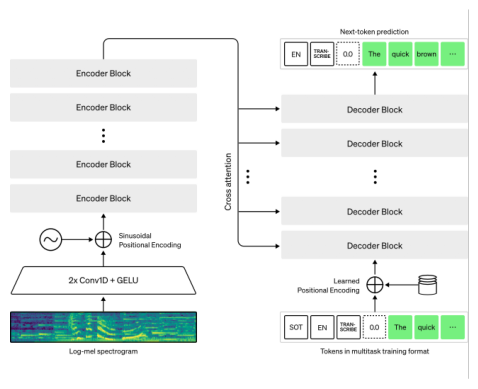

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.7whisper_architecture.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

看起来十分熟悉。左边是Transformer编码器。它以对数梅尔时频谱（log-mel spectrogram）作为输入，并对其进行编码，输出一个编码器隐藏状态序列（sequence of encoder hidden states），从中提取出输入语音的重要特征。这个隐藏状态张量代表了整个输入序列，并高效地编码了输入语音的“含义”。

<font style=background:green>💡 这些seq2seq模型通常使用时频谱作为输入。不过，seq2seq模型也可以直接使用音频波形作为输入。</font>

编码器的输出被传递到右边的Transformer解码器，使用一种称为交叉注意力（cross-attention）的机制。交叉注意力与自注意力类似，不过此处注意力的对象是编码器的输出。在这之后，我们就不再需要编码器了。

解码器会使用自回归（autoregressive）的方式来预测一个文本标记序列，每次只预测一个标记，从一个仅含有“起始”标记（Whisper使用SOT作为起始标记）的序列开始。在每个时间步，前一个时间步的输出序列会作为新的输入序列被传递给解码器。这样，解码器每次只会输出一个新的标记，逐步增长输出序列，直到预测出“结束”标记，或者达到最大时间步数。

虽然解码器的结构与编码器类似，但是解码器和编码器有两个主要的区别：

解码器会使用交叉注意力机制，允许它查看编码器生成的对于输入序列的隐藏状态向量。
解码器的注意力是因果（causal）的——解码器不允许查看未来的信息。

在这个架构中，解码器的功能类似于语言模型（language model），它处理编码器的隐藏状态表示，并生成相应的文本转录。这种方法比CTC更强大，甚至CTC结合外部语言模型也无法相比。Seq2Seq结构可以使用相同的训练数据和损失函数进行端到端（end-to-end）训练，从而提供更好的灵活性和更好的性能。

<font style=background:green>💡 与CTC模型输出单个字母的序列不同，Whisper模型的输出是完整的单词或词素。它使用GPT-2的分词器，有50k+个不同的标记。因此，seq2seq模型可以输出比CTC模型更短的序列。</font>

Seq2Seq语音识别模型最常使用的损失函数为交叉熵损失（cross-entropy loss），因为我们通常把模型最终层的输出视为一个标记的概率分布。交叉熵损失通常与束搜索（beam search）等技术结合使用，生成最终的序列。语音识别的度量标准是WER（word error rate），它衡量将预测文本转换为目标文本所需的替换、插入和删除的数量。所需的操作越少说明预测结果越好。

### 文本到语音（Text-to-speech，TTS）

可能不会让你感到惊讶的是， Seq2Seq的TTS模型基本上和ASR模型相同，仅仅是将输入和输出的数据种类互换！Transformer编码器接收文本标记序列，并提取表示输入文本的隐藏状态序列。Transformer解码器使用交叉注意力机制，预测输出的时频谱序列。

<font style=background:green>💡 时频谱图是通过对音频波形的连续时间切片进行频谱分析得到的。换句话说，时频谱图是一个序列，其中的元素是（对数梅尔）频谱，每个时间步一个。</font>

在ASR模型里，解码器的初始输出序列是一个仅包含“起始”标记的序列。而在TTS模型里，我们可以使用一个长度为1，值全为0的时频谱序列来代替“起始”标记。有了这个初始时频谱序列和编码器隐藏状态的交叉注意力，解码器就可以预测下一个时间步的时频谱，逐步增长时频谱序列。

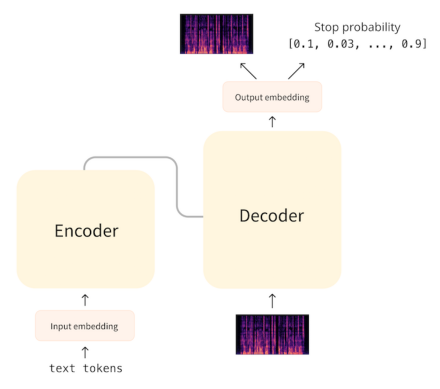

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.8speecht5_decoding.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

但我们的解码器怎样知道需要在什么时候停止呢？在SpeechT5模型中，解码器会预测第二个序列。这个序列包含当前时间步是否是最后一个时间步的概率。在推理时，如果这个概率超过某个阈值（比如0.5），我们就认为解码器在指示时频谱序列已经生成完毕，应该结束生成循环。

在解码器生成完整的时频谱序列后，SpeechT5会使用一个称为后处理网络（post-net）的模型对时频谱序列进行微调。后处理网络由几个卷积层组成，用于微调时频谱序列。

在训练TTS模型时，我们的生成目标是训练数据的时频谱图，损失函数为L1损失或最小二乘损失（mean square error，MSE）。在推理时，我们希望将输出的时频谱图转换为音频波形，这样我们就可以听到它。为此，我们需要使用一个外部模型，称为声码器（vocoder）。这个声码器不是seq2seq架构的一部分，而是单独训练的。

TTS任务的难点在于其一对多的映射。对于语音到文本的任务，每个输入语音只对应一个正确的输出文本，但是对于文本到语音的任务，输入文本可以映射到多个可能的语音。例如，不同的说话人可能会强调同一个句子中的不同部分。这使得TTS模型很难评估。因为这个原因，L1或MSE损失实际上并不是理想的损失函数，因为同一个文本可以映射到多种不同的时频谱序列。这就是为什么TTS模型通常会由人类听众进行评估的原因，使用的指标称为MOS（mean opinion score，平均意见分数）。

### 总结

Seq2Seq结构是一种强大的模型，其能力往往优于仅含编码器的模型。通过将输入序列的编码与输出序列的解码分离，我们可以很好地处理音频和文本的对齐问题。

然而，编码器-解码器模型也存在一些缺点，比较重要的一点是其推理速度较慢。这是由于其解码过程在每一步仅生成一个输出元素，因此完整的预测需要进行数次推理。输出序列越长，推理的速度也就越慢。自回归模型也可能会陷入循环或者跳过一些元素。束搜索（beam search）等技术可以提高预测结果的质量，但也会进一步降低推理速度。

## 音频分类结构

音频分类任务的目标是预测音频输出的分类标签。分类模型可以为整个输入序列预测一个标签，也可以为每一帧预测一个不同的标签。在分帧预测时，模型通常为每20毫秒的输入音频预测一个标签，并生成一个由分类标签概率分布组成的序列。预测单一标签的例子如预测音频中发出声音的鸟的种类；预测分帧标签的例子如说话人识别，每帧都可能由不同的说话人在发出声音。

### 使用时频谱进行分类

最简单的音频分类方法之一是将其视为一个图像分类问题！

回想一下，时频谱是一个形状为（频率，序列长度）的二维张量。在音频数据章节中，我们学习过将这些时频谱绘制为图像。没错，我们可以直接将时频谱视为图像，并将其传递给一个常见的CNN分类器模型，如ResNet，并获得非常好的预测结果。更好的是，也可以使用图像Transformer模型，如ViT。

这就是AST（Audio Spectrogram Transformer）的作用。它使用ViT（即Vision Transformer）模型，并使用时频谱而非常规图像作为输入。由于Transformer的自注意层，该模型能够比CNN更好地捕获全局上下文。

与ViT一样，AST模型将音频时频谱分成16×16像素的部分重叠的图像块（image patch）序列。然后，我们将此序列中的块投影到嵌入序列中，并像往常一样将其作为输入传递给Transformer编码器。AST是一个仅含编码器的Transformer模型，因此输出是一个隐藏状态序列，每个16×16输入块对应一个隐藏状态。最后是一个含有sigmoid激活函数的简单分类层，将隐藏状态映射为分类概率。

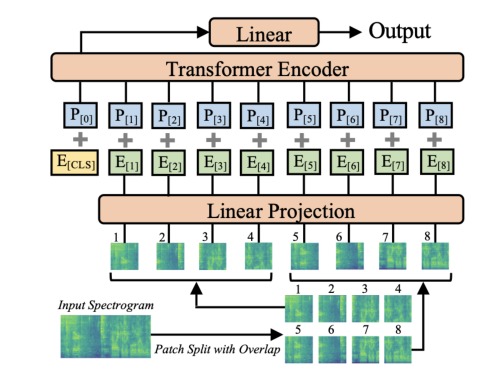

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/3.9ast.png')
pic.shape
plt.imshow(pic)
plt.axis('off') 
plt.show()

<font style=background:green>💡 尽管在这里我们假装时频谱与图像相同，但它们之间其实有重要的区别。例如，将图像的内容上下平移通常不会改变图像中的内容的含义。然而，将时频谱上下平移将改变声音中的频率，并完全改变其特性。图像具有一定的上下和左右平移不变性（shift-invariance），但时频谱仅具有一定的左右平移不变性，而几乎完全不具有上下平移不变性。尽管在实践中，将时频谱视为图像可以得到很好的效果，但请记住它们在原理上完全不同。</font>

### 任何Transformer都可以是分类器

在CTC一节中，我们了解到CTC是一种使用仅含编码器的Transformer来执行自动语音识别的有效技术。CTC模型实际上已经可以被视为分类器，因为其预测的是词汇表中每个词素的概率。我们可以通过更改标签并使用常规的交叉熵损失函数代替特殊的CTC损失来将CTC模型转换为通用的音频分类器。

举个例子，HF Transformers库中包含了Wav2Vec2ForCTC模型，但提供了Wav2Vec2ForSequenceClassification和Wav2Vec2ForAudioFrameClassification。这些模型之间的唯一区别是分类层的大小和所使用的损失函数。

实际上，任何仅含编码器的音频Transformer模型都可以通过在隐藏状态序列之上添加分类层来转换为音频分类器。分类任务通常不需要Transformer解码器。

如果需要对整个序列输出一个单独的分类标签（Wav2Vec2ForSequenceClassification），模型会对隐藏状态序列沿其长度取平均值，并将其输送到分类层。这样我们就可以对整个序列输出一个概率分布，而不是输出序列中每个元素的概率分布。

如果需要对每一帧输出一个分类标签（Wav2Vec2ForAudioFrameClassification），我们就让分类器对隐藏状态序列中的每个元素都输出一个概率分布，这样我们的输出会成为一个具有同样长度的概率分布序列。